Грузим либы

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

Грузим данные

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

Train shape: (1117957, 22)
Test shape: (745305, 21)



Проверка качества данных

In [3]:
print(f'Train: {train.isnull().sum().sum()} пропусков')
print(f'Test: {test.isnull().sum().sum()} пропусков')

print('Train:')
print(train.dtypes.value_counts())
print('\nTest:')
print(test.dtypes.value_counts())

Train: 0 пропусков
Test: 0 пропусков
Train:
int64      21
float64     1
Name: count, dtype: int64

Test:
int64    21
Name: count, dtype: int64


## 1. Анализ распределения целевой переменной

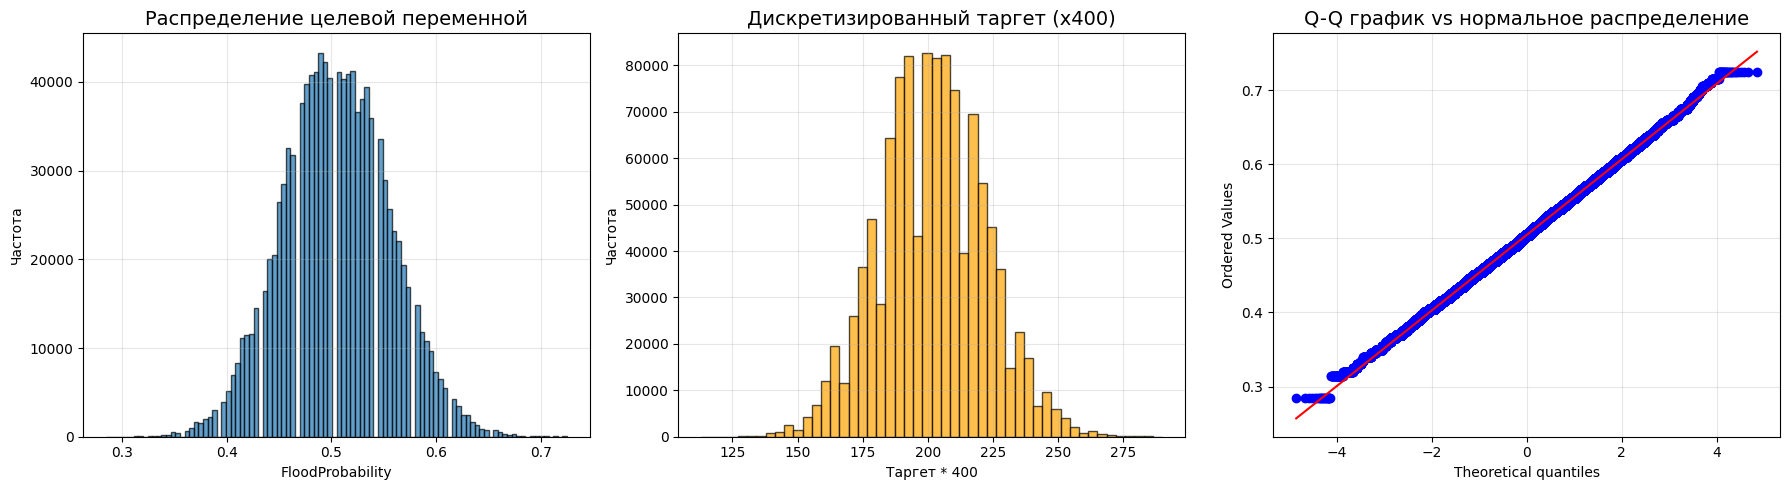

In [4]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(train['FloodProbability'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_title('Распределение целевой переменной', fontsize=14)
axes[0].set_xlabel('FloodProbability')
axes[0].set_ylabel('Частота')
axes[0].grid(alpha=0.3)

target_discrete = (train['FloodProbability'] * 400).astype(np.int16)
axes[1].hist(target_discrete, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[1].set_title('Дискретизированный таргет (x400)', fontsize=14)
axes[1].set_xlabel('Таргет * 400')
axes[1].set_ylabel('Частота')
axes[1].grid(alpha=0.3)

stats.probplot(train['FloodProbability'], dist='norm', plot=axes[2])
axes[2].set_title('Q-Q график vs нормальное распределение', fontsize=14)
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Анализ агрегированных признаков

Корреляция (sum, FloodProbability): 0.919205


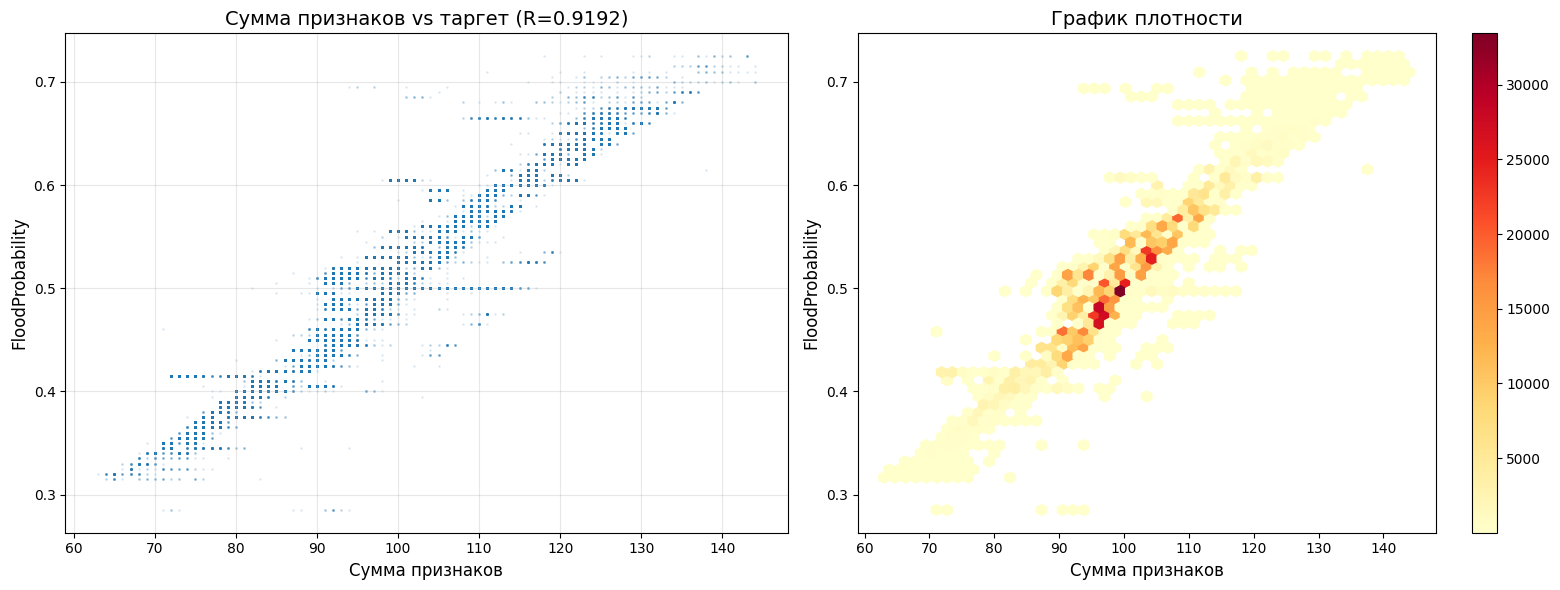

In [5]:
original_features = [c for c in train.columns if c not in ['id', 'FloodProbability']]

train['sum'] = train[original_features].sum(axis=1)
test['sum'] = test[original_features].sum(axis=1)

corr = train[['sum', 'FloodProbability']].corr().iloc[0, 1]

print(f'Корреляция (sum, FloodProbability): {corr:.6f}')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(train['sum'], train['FloodProbability'], alpha=0.1, s=1)
axes[0].set_xlabel('Сумма признаков', fontsize=12)
axes[0].set_ylabel('FloodProbability', fontsize=12)
axes[0].set_title(f'Сумма признаков vs таргет (R={corr:.4f})', fontsize=14)
axes[0].grid(alpha=0.3)

axes[1].hexbin(train['sum'], train['FloodProbability'], gridsize=50, cmap='YlOrRd', mincnt=1)
axes[1].set_xlabel('Сумма признаков', fontsize=12)
axes[1].set_ylabel('FloodProbability', fontsize=12)
axes[1].set_title('График плотности', fontsize=14)
plt.colorbar(axes[1].collections[0], ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Статистические признаки на основе группировки

Признак на основе группировки: std(FloodProbability) по sum
Уникальных значений sum: 82
Диапазон std: [0.001946, 0.029640]


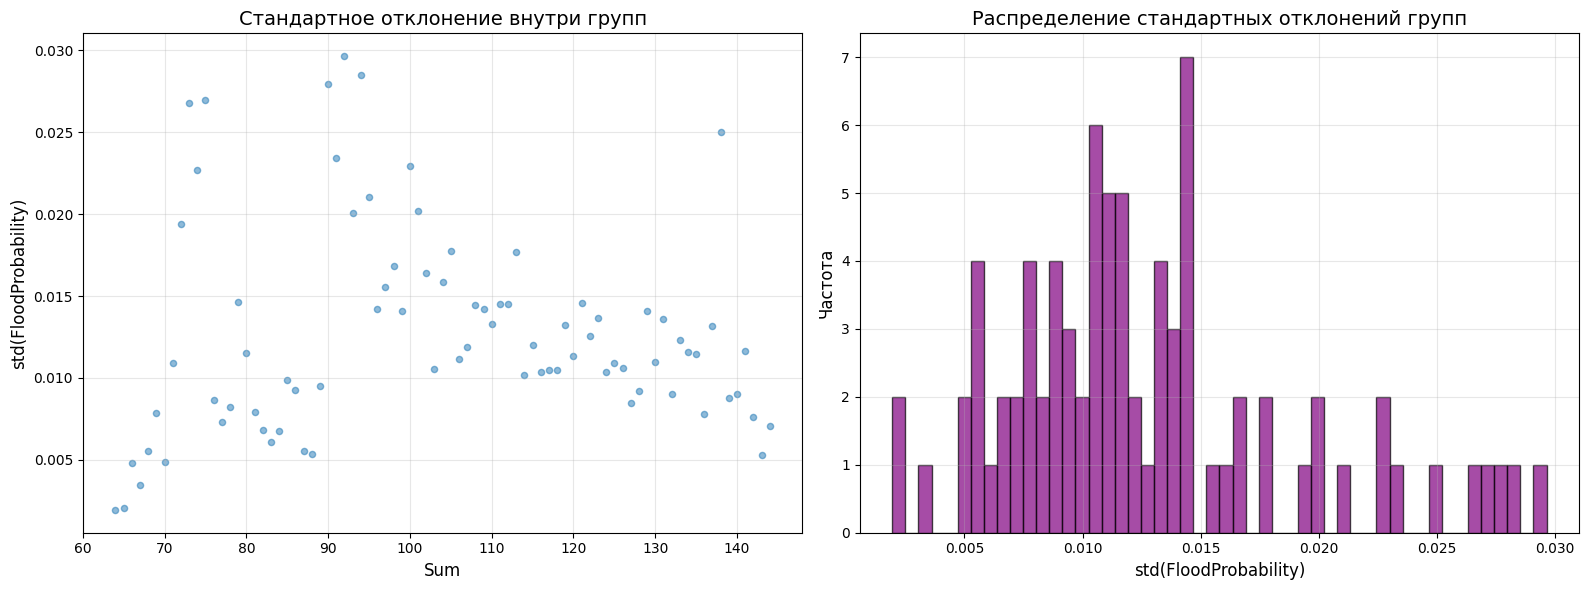

In [6]:
magic_std = train.groupby('sum')['FloodProbability'].std()

print(f'Признак на основе группировки: std(FloodProbability) по sum')
print(f'Уникальных значений sum: {len(magic_std)}')
print(f'Диапазон std: [{magic_std.min():.6f}, {magic_std.max():.6f}]')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(magic_std.index, magic_std.values, alpha=0.5, s=20)
axes[0].set_xlabel('Sum', fontsize=12)
axes[0].set_ylabel('std(FloodProbability)', fontsize=12)
axes[0].set_title('Стандартное отклонение внутри групп', fontsize=14)
axes[0].grid(alpha=0.3)

axes[1].hist(magic_std.values, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[1].set_xlabel('std(FloodProbability)', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение стандартных отклонений групп', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Анализ корреляции признаков

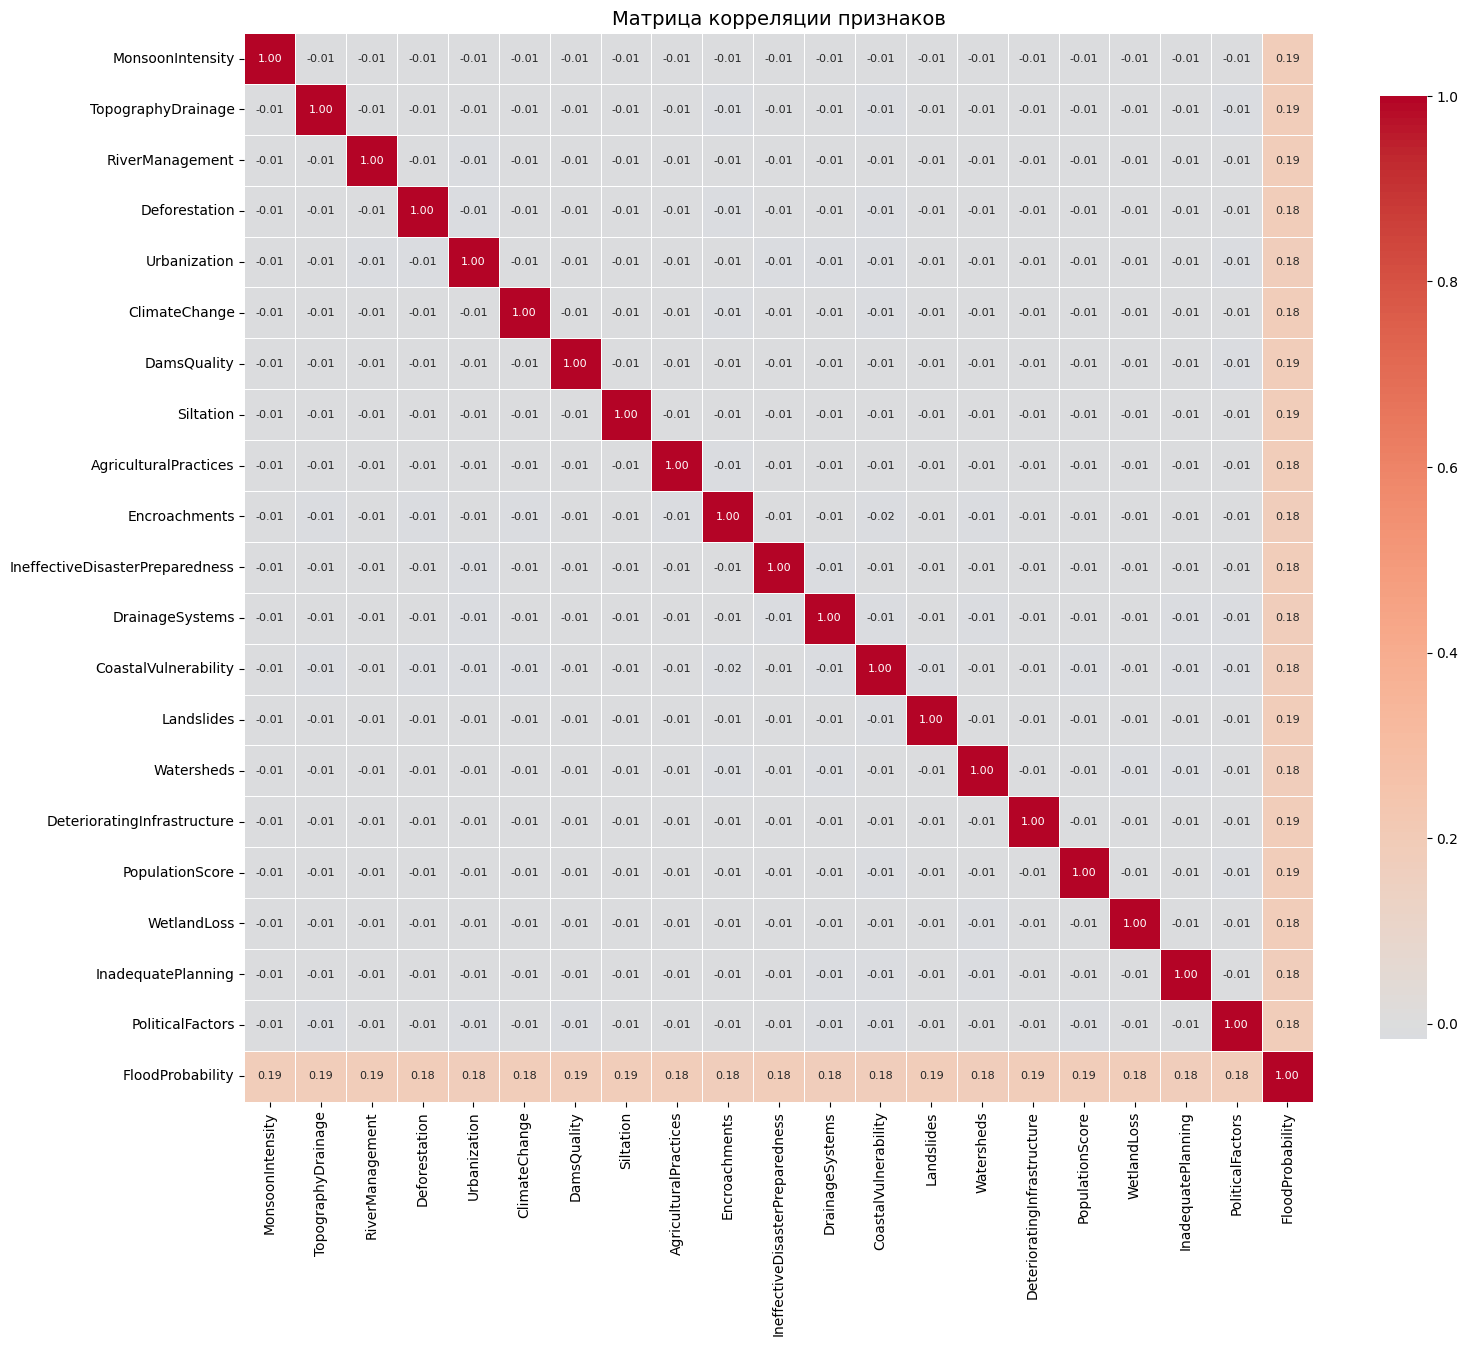

In [7]:
correlation_matrix = train[original_features + ['FloodProbability']].corr()

correlations = correlation_matrix['FloodProbability'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, 
            annot_kws={'size': 8}, ax=ax)
ax.set_title('Матрица корреляции признаков', fontsize=14)
plt.tight_layout()
plt.show()

## 5. Анализ отсортированных признаков

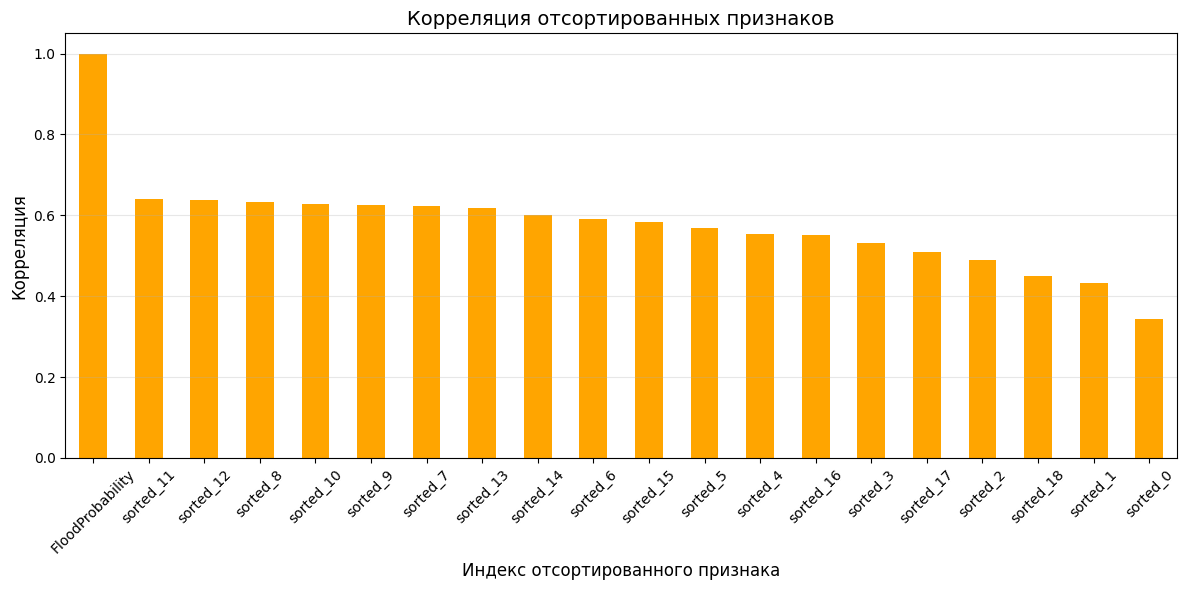

In [8]:
sorted_vals = np.sort(train[original_features].values, axis=1)
sorted_df = pd.DataFrame(sorted_vals, columns=[f'sorted_{i}' for i in range(len(original_features))])
sorted_df['FloodProbability'] = train['FloodProbability'].values

sorted_corr = sorted_df.corr()['FloodProbability'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))
sorted_corr[:-1].plot(kind='bar', ax=ax, color='orange')
ax.set_xlabel('Индекс отсортированного признака', fontsize=12)
ax.set_ylabel('Корреляция', fontsize=12)
ax.set_title('Корреляция отсортированных признаков', fontsize=14)
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 6. Признаки подсчета на основе порогов

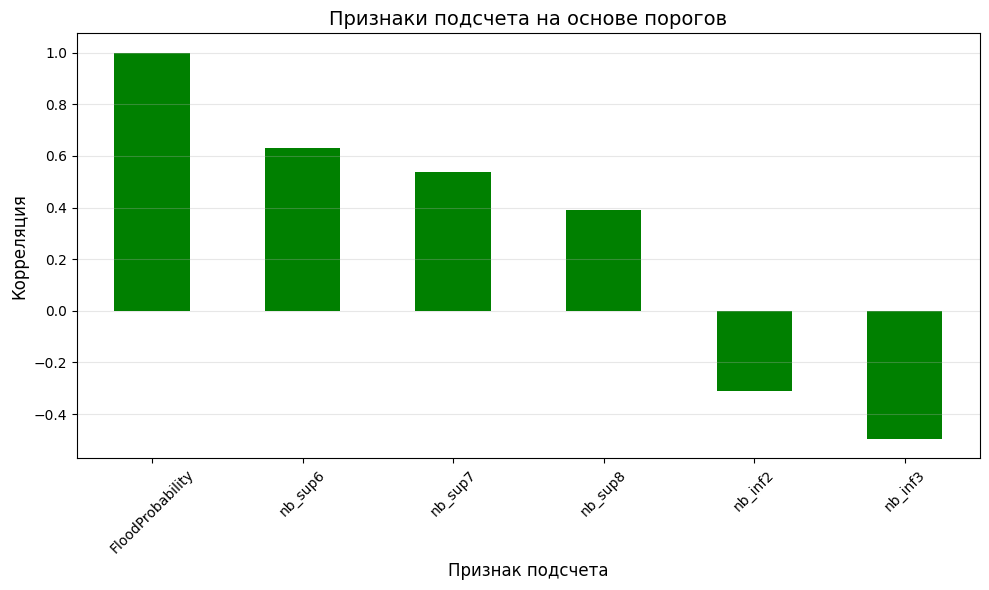

In [9]:
count_features = pd.DataFrame()
for threshold in [6, 7, 8]:
    count_features[f'nb_sup{threshold}'] = (train[original_features] > threshold).sum(axis=1)
for threshold in [2, 3, 4]:
    count_features[f'nb_inf{threshold}'] = (train[original_features] < threshold).sum(axis=1)

count_features['FloodProbability'] = train['FloodProbability'].values

count_corr = count_features.corr()['FloodProbability'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
count_corr[:-1].plot(kind='bar', ax=ax, color='green')
ax.set_xlabel('Признак подсчета', fontsize=12)
ax.set_ylabel('Корреляция', fontsize=12)
ax.set_title('Признаки подсчета на основе порогов', fontsize=14)
ax.grid(alpha=0.3, axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 7. Распределение признаков

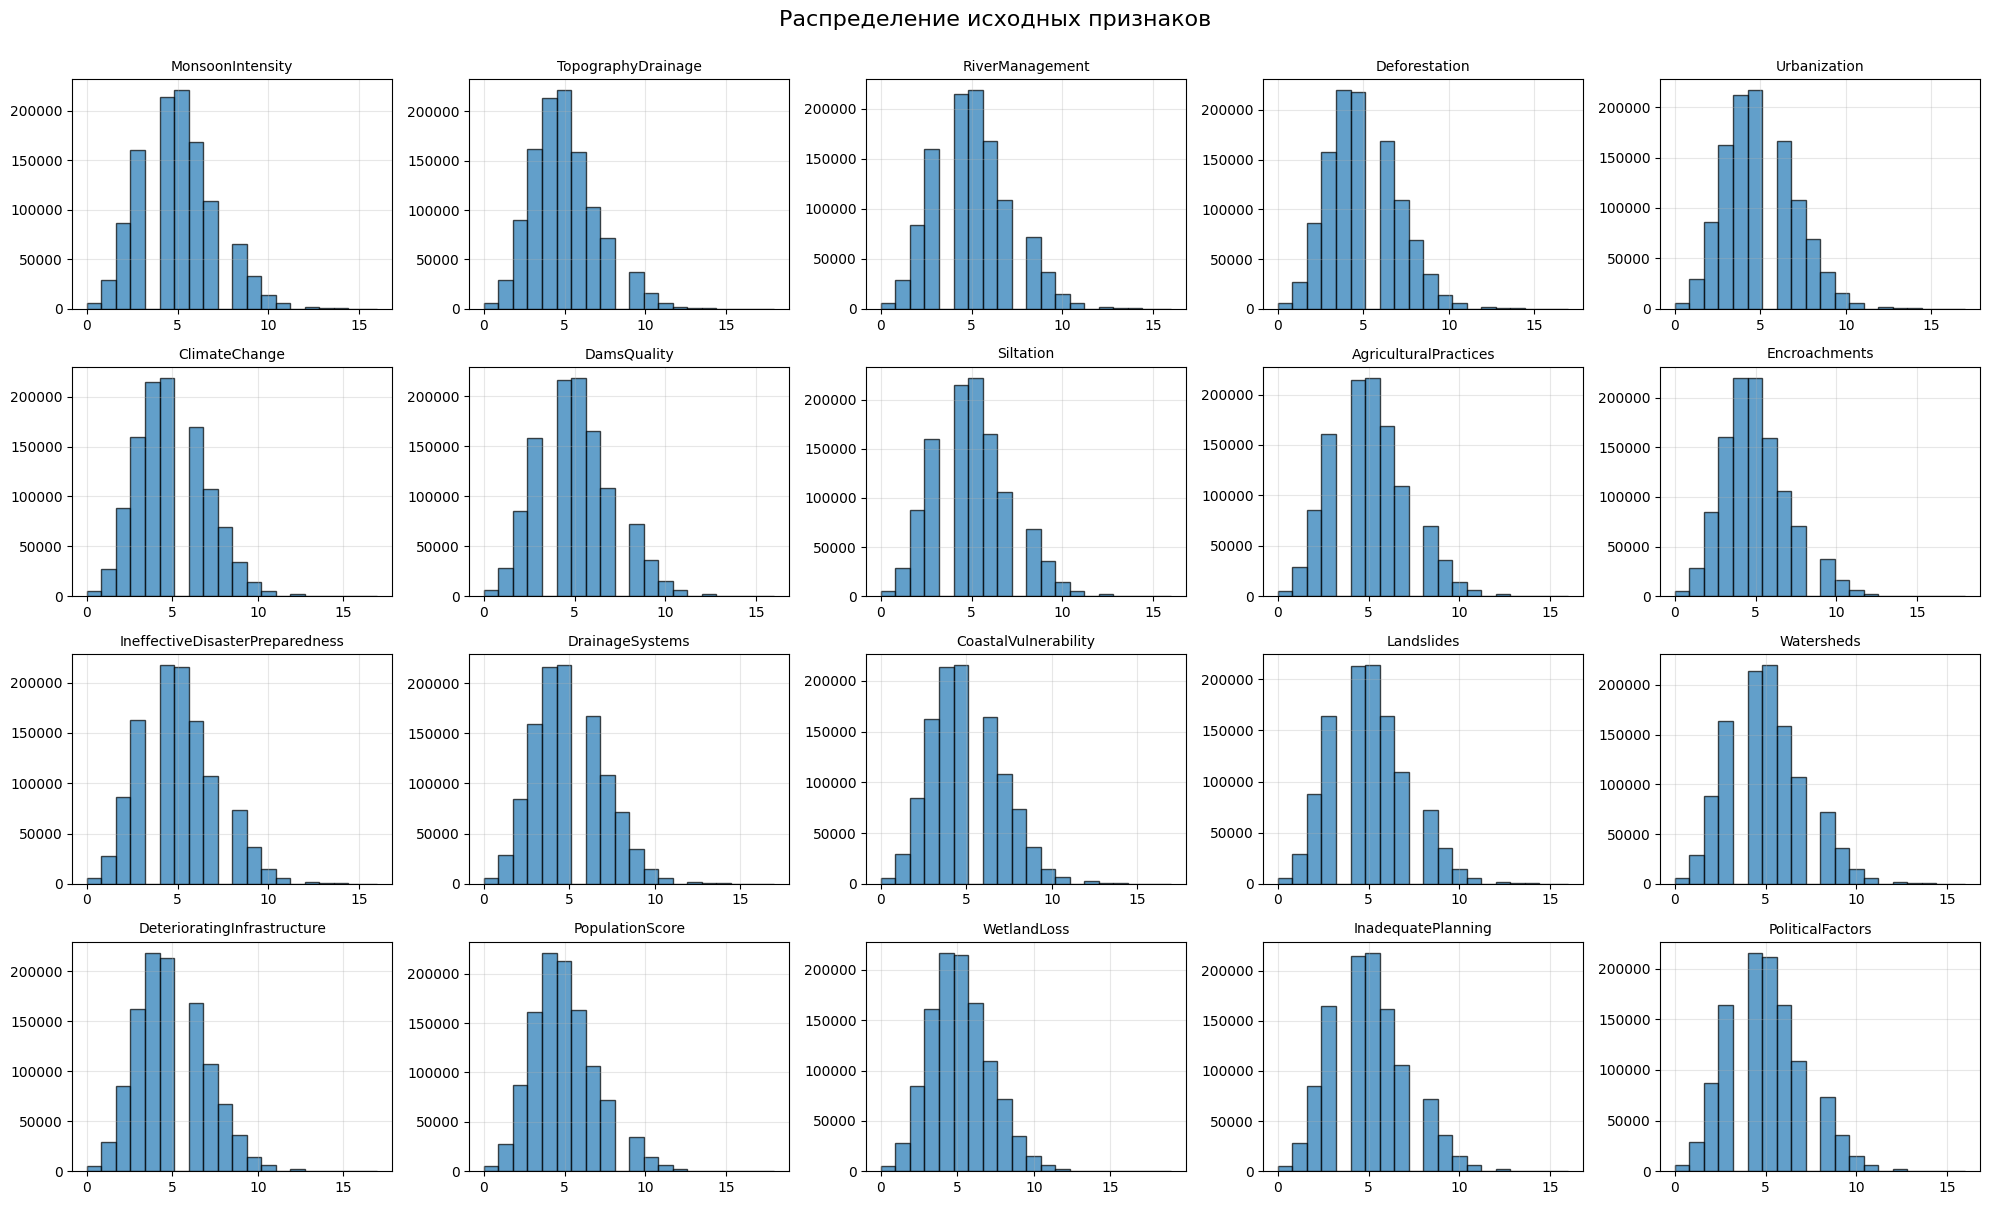

In [10]:
fig, axes = plt.subplots(4, 5, figsize=(20, 12))
axes = axes.flatten()

for i, feat in enumerate(original_features):
    axes[i].hist(train[feat], bins=20, edgecolor='black', alpha=0.7)
    axes[i].set_title(feat, fontsize=10)
    axes[i].grid(alpha=0.3)

plt.suptitle('Распределение исходных признаков', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()